In [9]:
import numpy as np
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers import SetResolution, ToDiscrete
from gym.wrappers import SkipWrapper
from gym import wrappers

from skimage.transform import resize
from skimage.color import rgb2gray
import types    

    
def resize_observation_patch(env, size):
    """ Because unfortunately SetResolution also impacts the recorded videos...
    """
    def resized_obs(obs):
        return resize(rgb2gray(obs), size).reshape(size + (-1,))
                                                           
    original_reset = env.reset
    def reset_with_resized_obs(self):
        observation = original_reset()
        return resized_obs(observation)

    original_step = env.step
    def step_with_resized_obs(self, action):
        observation, reward, done, end = original_step(action)
        return resized_obs(observation), reward, done, end

    env.step = types.MethodType(step_with_resized_obs, env)
    env.reset = types.MethodType(reset_with_resized_obs, env)
    return env

WIDTH, HEIGHT, CHANNELS = 200, 150, 3

# (see https://github.com/ppaquette/gym-doom/blob/master/ppaquette_gym_doom/doom_basic.py)
def create_env(seed=None, monitor_directory=None, size=(WIDTH, HEIGHT)):
    env_spec = gym.spec('ppaquette/DoomBasic-v0')
    env_spec.id = 'DoomBasic-v0'
    env = env_spec.make()

    if seed is not None:
        env.seed(seed)

    if monitor_directory is not None:
        env = wrappers.Monitor(env, monitor_directory, force=True, mode='training', 
                               video_callable=lambda episode_id: episode_id % 100 == 0)

    return SetResolution('200x150')(
        SkipWrapper(repeat_count=4)(
        ToDiscrete('minimal')(env)))
    #return resize_observation_patch(size=size,
    #                                env=SkipWrapper(repeat_count=4)(ToDiscrete('minimal')(env)))

env = create_env()


NOOP, SHOOT, RIGHT, LEFT = 0, 1, 2, 3

(150, 200, 3)


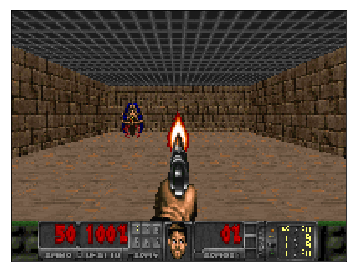

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

obs = env.reset()
obs, _, _, _ = env.step(action=1)

plt.figure(figsize=[6, 6])

print(obs.shape)
def show(observation):
    plt.imshow(observation, interpolation=None)
    #plt.imshow(observation.reshape((HEIGHT, WIDTH)), interpolation=None, cmap='gray')
    plt.xticks([]); plt.yticks([]);
    
show(obs)
env.close()

## Deep Q-learning

 * https://github.com/coreylynch/async-rl/blob/master/model.py and https://github.com/tflearn/tflearn/blob/master/examples/reinforcement_learning/atari_1step_qlearning.py with 84 x 84 images

```
    net = tflearn.conv_2d(net, 32, 8, strides=4, activation='relu')
    net = tflearn.conv_2d(net, 64, 4, strides=2, activation='relu')
    net = tflearn.fully_connected(net, 256, activation='relu')
```

 * https://github.com/ebonyclock/deep_rl_vizdoom/blob/master/networks/common.py#L20 with 80 x 60 images
 
```
    conv1 = layers.conv2d(img_input, num_outputs=8, kernel_size=[6, 6], stride=3, padding="VALID", ...)
    conv2 = layers.conv2d(conv1, num_outputs=8, kernel_size=[3, 3], stride=2, padding="VALID", ...)

```
 * From http://vizdoom.cs.put.edu.pl/tutorial#learning with images (30, 45)!
```
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[6, 6], nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=3)
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[3, 3],nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=2)
dqn = DenseLayer(dqn, num_units=128, nonlinearity=rectify, W=HeUniform("relu"), b=Constant(.1))
```
 

In [13]:
import tensorflow as tf
from keras import backend as K

from keras.layers import Dense, Convolution2D, Flatten, Activation
from keras.models import Sequential
from keras.optimizers import Adam

sess = tf.InteractiveSession()
K.set_session(sess)

def create_q_model(conv1_weights=None, conv2_weights=None, dense1_weights=None, dense2_weights=None):
    model = Sequential()

    #model.add(Input(shape=(agent_history_length, resized_width, resized_height,)))
    model.add(
        Convolution2D(nb_filter=8, nb_row=6, nb_col=6, subsample=(3, 3), border_mode='same', weights=conv1_weights,
            input_shape=[HEIGHT, WIDTH, CHANNELS], dim_ordering='tf'))
    model.add(Activation('relu'))
    model.add(
        Convolution2D(nb_filter=8, nb_row=3, nb_col=3, subsample=(2, 2),  border_mode='same', weights=conv2_weights, dim_ordering='tf'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, init='normal', weights=dense1_weights))
    model.add(Activation('relu'))
    model.add(Dense(4, init='normal', weights=dense2_weights))
    model.compile(loss='mse', optimizer=Adam())
    
    return model

acting_model = create_q_model()
target_model = create_q_model()

def copy_model(model):
    conv1_weights =  [w.eval() for w in model.layers[0].weights]
    conv2_weights = [w.eval() for w in model.layers[2].weights]
    dense1_weights = [w.eval() for w in model.layers[5].weights]
    dense2_weights = [w.eval() for w in model.layers[7].weights]
    return create_q_model(conv1_weights, conv2_weights, dense1_weights, dense2_weights)

acting_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_345 (Convolution2D (None, 50, 67, 8)     872         convolution2d_input_173[0][0]    
____________________________________________________________________________________________________
activation_517 (Activation)      (None, 50, 67, 8)     0           convolution2d_345[0][0]          
____________________________________________________________________________________________________
convolution2d_346 (Convolution2D (None, 25, 34, 8)     584         activation_517[0][0]             
____________________________________________________________________________________________________
activation_518 (Activation)      (None, 25, 34, 8)     0           convolution2d_346[0][0]          
___________________________________________________________________________________________

## Collecting and preparing experiences for learning

In [14]:
# from https://docs.python.org/3/library/itertools.html#recipes
from itertools import tee, zip_longest

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [15]:
from collections import namedtuple, deque
from itertools import islice 
import operator
import functools
import random


SARE = namedtuple('SAR', ['state', 'action', 'reward', 'end'])
Experience = namedtuple('Experience', ['previous_state', 'action', 'reward', 'next_state', 'end'])


class EpsilonGreedyQAgent(object):
    def __init__(self, model, epsilon=.1):
        self.model = model
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice([NOOP, SHOOT, LEFT, RIGHT])
        else:
            return self.model.predict(observation[np.newaxis])[0].argmax()


def generate_sares(env, agent, episode_count=2000):
    reward = 0
    done = False

    for i in range(episode_count):
        if (i % 10) == 0:
            print('episode {i}'.format(i=i))
        observation = env.reset()
        while True:
            action = agent.act(observation, reward, done)
            new_observation, reward, done, _ = env.step(action)
            yield SARE(observation, action, reward, done)
            
            if done:
                break
            else:
                observation = new_observation


env = create_env()
sares = generate_sares(env, EpsilonGreedyQAgent(acting_model), episode_count=1000)

experiences = (
    Experience(previous_s, a, r, next_s, end) 
    for (previous_s, a, r, end), (next_s, _, _, _) 
    in pairwise(sares))


experience_batches = grouper(experiences, n=200)

print(len(list(next(experience_batches))))
env.close()

episode 0


Exception ignored in: <bound method Env.__del__ of <SkipWrapper<ToDiscreteWrapper<_Monitor<TimeLimit<DoomBasicEnv instance>>>>>>
Traceback (most recent call last):
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 252, in __del__
    self.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/wrappers/monitoring.py", line 38, in _close
    

200


In [16]:
from itertools import islice

class ExperiencesReplay:
    def __init__(self, experiences_iterable, memory_size=50, batch_size=32):
        self.experiences_iterable = experiences_iterable
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)

    def __iter__(self):
        return self

    def __next__(self):
        for exp in islice(self.experiences_iterable, self.batch_size):
            self.memory.appendleft(exp)
        sampled_experiences = random.choices(self.memory, k=self.batch_size)
        return sampled_experiences
    
env = create_env()

experiences = (
    Experience(previous_s, a, r, next_s, end) 
    for (previous_s, a, r, end), (next_s, _, _, _) 
    in pairwise(generate_sares(env, EpsilonGreedyQAgent(acting_model))))

replay = ExperiencesReplay(experiences)

print(len(next(replay)), len(replay.memory))
print(len(next(replay)), len(replay.memory))

env.close()

episode 0
32 32
32 50


## Training

In [17]:
N_BATCHES = 200


class DeepQNetworkTrainer:
    
    MINI_BATCH_SIZE = 128
    UPDATE_TARGET_EVERY_N_BACTHES = 5
    
    def __init__(self, acting_model, target_model, double_q=False, gamma=.99, reward_clip=5):
        self.acting_model = acting_model
        self.target_model = target_model
        self.double_q = double_q
        
        self.gamma = gamma
        self.reward_clip = reward_clip

        # counter to periodically set target_model <- acting_model
        self.trained_epochs = 0
    
    def fit_episodes(self, experiences_batch):
        prev_frames, target_action_rewards = self._batch_to_input_targets(experiences_batch, double_q=self.double_q)
        self.acting_model.fit(x=prev_frames, y=target_action_rewards, batch_size=self.MINI_BATCH_SIZE, nb_epoch=1, verbose=0)
        self.trained_epochs += 1

        if (self.trained_epochs % self.UPDATE_TARGET_EVERY_N_BACTHES) == 0:
            print('target_model <- acting_model')
            self.target_model = copy_model(self.acting_model)

    def _batch_to_input_targets(self, experiences_batch, double_q=False):
        
        experiences = list(filter(None, experiences_batch))
        random.shuffle(experiences)
        n_samples = len(experiences)

        prev_frames, actions, rewards, next_frames, is_ends = zip(*experiences)
        prev_frames = np.asarray(prev_frames)
        next_frames = np.asarray(next_frames)
        actions = np.asarray(actions)
        rewards = np.asarray(rewards)
        is_ends = np.asarray(is_ends)

        print('Batch of {} exps with avg reward {} and dist. {} and actions distribution {}'.format(
            n_samples,
            np.mean(rewards),
            np.histogram(rewards, bins=3)[0].tolist(),
            np.bincount(actions).tolist()))

        clipped_rewards = np.clip(rewards, -np.inf, self.reward_clip)

        if double_q:
            greedy_actions = self.acting_model.predict(next_frames).argmax(axis=1)
            actions_target_values = self.target_model.predict(next_frames)[np.arange(n_samples), greedy_actions]            
            targets = clipped_rewards + self.gamma * (1 - is_ends) * actions_target_values
        else:
            # Transcription of the Q-learning target formula
            targets = clipped_rewards + self.gamma * (1 - is_ends) * self.target_model.predict(next_frames).max(axis=1)

            target_action_rewards = self.target_model.predict(prev_frames)
            target_action_rewards[np.arange(n_samples), actions] = targets

            return prev_frames, target_action_rewards

directory = 'tmp/DoomBasic_dqn_replay'
env = create_env(monitor_directory=directory)

trainer = DeepQNetworkTrainer(acting_model, target_model)

experiences = (
    Experience(previous_s, a, r, next_s, end) 
    for (previous_s, a, r, end), (next_s, _, _, _) 
    in pairwise(generate_sares(env, EpsilonGreedyQAgent(acting_model))))

#experience_batches = ExperiencesReplay(experiences, memory_size=1000, batch_size=128)
experience_batches = grouper(experiences, n=128)

for experience_batch in experience_batches:
    trainer.fit_episodes(experience_batch)
    
# final greedy episodes
sares = list(generate_sares(env, EpsilonGreedyQAgent(acting_model, epsilon=0), episode_count=100))

env.close()
gym.upload(directory, api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-03-12 08:42:55,986] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-12 08:42:55,988] Clearing 42 monitor files from previous run (because force=True was provided)
[2017-03-12 08:42:56,320] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000000.mp4


episode 0
Batch of 128 exps with avg reward -3.7265625 and dist. [125, 0, 3] and actions distribution [48, 40, 22, 18]
Batch of 128 exps with avg reward -5.3125 and dist. [8, 0, 120] and actions distribution [117, 8, 1, 2]
Batch of 128 exps with avg reward -5.078125 and dist. [2, 0, 126] and actions distribution [117, 2, 6, 3]
Batch of 128 exps with avg reward -5.15625 and dist. [4, 0, 124] and actions distribution [116, 4, 6, 2]
episode 10
Batch of 128 exps with avg reward -5.078125 and dist. [2, 0, 126] and actions distribution [121, 2, 1, 4]
target_model <- acting_model
Batch of 128 exps with avg reward -4.25 and dist. [127, 0, 1] and actions distribution [119, 2, 2, 5]
Batch of 128 exps with avg reward -5.078125 and dist. [2, 0, 126] and actions distribution [124, 2, 2]
Batch of 128 exps with avg reward -5.0390625 and dist. [1, 0, 127] and actions distribution [121, 1, 2, 4]
Batch of 128 exps with avg reward -5.0 and dist. [0, 128, 0] and actions distribution [124, 0, 0, 4]
episode

[2017-03-12 08:44:59,577] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000100.mp4


episode 100
Batch of 128 exps with avg reward -4.1171875 and dist. [126, 0, 2] and actions distribution [36, 21, 29, 42]
target_model <- acting_model
Batch of 128 exps with avg reward -4.71875 and dist. [127, 0, 1] and actions distribution [42, 15, 28, 43]
Batch of 128 exps with avg reward -5.390625 and dist. [10, 0, 118] and actions distribution [34, 11, 30, 53]
episode 110
Batch of 128 exps with avg reward -4.046875 and dist. [126, 0, 2] and actions distribution [33, 21, 29, 45]
Batch of 128 exps with avg reward -4.7578125 and dist. [127, 0, 1] and actions distribution [42, 20, 40, 26]
Batch of 128 exps with avg reward -3.171875 and dist. [125, 0, 3] and actions distribution [33, 19, 44, 32]
target_model <- acting_model
Batch of 128 exps with avg reward -5.03125 and dist. [127, 0, 1] and actions distribution [37, 23, 32, 36]
episode 120
Batch of 128 exps with avg reward -4.46875 and dist. [126, 0, 2] and actions distribution [23, 36, 29, 40]
Batch of 128 exps with avg reward -4.28125

[2017-03-12 08:46:34,827] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000200.mp4


episode 200
Batch of 128 exps with avg reward -5.3046875 and dist. [127, 0, 1] and actions distribution [19, 32, 32, 45]
Batch of 128 exps with avg reward -5.15625 and dist. [127, 0, 1] and actions distribution [27, 32, 33, 36]
Batch of 128 exps with avg reward -5.0703125 and dist. [127, 0, 1] and actions distribution [36, 32, 36, 24]
episode 210
Batch of 128 exps with avg reward -2.546875 and dist. [124, 0, 4] and actions distribution [41, 26, 38, 23]
Batch of 128 exps with avg reward -5.1875 and dist. [127, 0, 1] and actions distribution [33, 36, 27, 32]
target_model <- acting_model
Batch of 128 exps with avg reward -4.46875 and dist. [126, 0, 2] and actions distribution [30, 39, 25, 34]
Batch of 128 exps with avg reward -5.0546875 and dist. [127, 0, 1] and actions distribution [29, 28, 25, 46]
episode 220
Batch of 128 exps with avg reward -4.15625 and dist. [126, 0, 2] and actions distribution [26, 23, 37, 42]
Batch of 128 exps with avg reward -3.3359375 and dist. [125, 0, 3] and ac

[2017-03-12 08:48:22,095] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000300.mp4


episode 300
Batch of 128 exps with avg reward -5.2265625 and dist. [127, 0, 1] and actions distribution [34, 38, 22, 34]
Batch of 128 exps with avg reward -5.0234375 and dist. [127, 0, 1] and actions distribution [26, 29, 29, 44]
Batch of 128 exps with avg reward -2.6484375 and dist. [124, 0, 4] and actions distribution [37, 33, 23, 35]
episode 310
Batch of 128 exps with avg reward -3.5703125 and dist. [125, 0, 3] and actions distribution [35, 35, 32, 26]
Batch of 128 exps with avg reward -5.703125 and dist. [18, 0, 110] and actions distribution [65, 22, 15, 26]
target_model <- acting_model
Batch of 128 exps with avg reward -3.6171875 and dist. [125, 0, 3] and actions distribution [38, 38, 23, 29]
episode 320
Batch of 128 exps with avg reward -5.3828125 and dist. [127, 0, 1] and actions distribution [24, 47, 26, 31]
Batch of 128 exps with avg reward -6.0546875 and dist. [27, 0, 101] and actions distribution [15, 43, 34, 36]
Batch of 128 exps with avg reward -5.09375 and dist. [127, 0, 

[2017-03-12 08:49:55,603] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000400.mp4


episode 400
Batch of 128 exps with avg reward -1.0703125 and dist. [122, 0, 6] and actions distribution [26, 30, 35, 37]
episode 410
Batch of 128 exps with avg reward -1.484375 and dist. [123, 0, 5] and actions distribution [40, 17, 34, 37]
Batch of 128 exps with avg reward -3.5234375 and dist. [125, 0, 3] and actions distribution [21, 34, 32, 41]
Batch of 128 exps with avg reward -6.2109375 and dist. [31, 0, 97] and actions distribution [18, 40, 31, 39]
Batch of 128 exps with avg reward -5.9765625 and dist. [25, 0, 103] and actions distribution [21, 31, 37, 39]
target_model <- acting_model
episode 420
Batch of 128 exps with avg reward -3.9296875 and dist. [126, 0, 2] and actions distribution [27, 19, 37, 45]
Batch of 128 exps with avg reward -3.8515625 and dist. [126, 0, 2] and actions distribution [43, 13, 45, 27]
Batch of 128 exps with avg reward -4.71875 and dist. [127, 0, 1] and actions distribution [44, 16, 42, 26]
episode 430
Batch of 128 exps with avg reward -5.9375 and dist. [

[2017-03-12 08:51:21,209] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000500.mp4


episode 500
Batch of 128 exps with avg reward -4.8359375 and dist. [127, 0, 1] and actions distribution [31, 19, 35, 43]
target_model <- acting_model
Batch of 128 exps with avg reward -4.1640625 and dist. [126, 0, 2] and actions distribution [38, 25, 31, 34]
Batch of 128 exps with avg reward -3.515625 and dist. [125, 0, 3] and actions distribution [31, 35, 29, 33]
episode 510
Batch of 128 exps with avg reward -0.34375 and dist. [121, 0, 7] and actions distribution [22, 36, 44, 26]
Batch of 128 exps with avg reward -5.1484375 and dist. [127, 0, 1] and actions distribution [24, 42, 49, 13]
episode 520
Batch of 128 exps with avg reward -5.1484375 and dist. [127, 0, 1] and actions distribution [26, 39, 34, 29]
target_model <- acting_model
Batch of 128 exps with avg reward -5.78125 and dist. [20, 0, 108] and actions distribution [31, 30, 30, 37]
Batch of 128 exps with avg reward -3.0625 and dist. [125, 0, 3] and actions distribution [39, 17, 32, 40]
episode 530
Batch of 128 exps with avg re

[2017-03-12 08:52:41,626] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000600.mp4


episode 600
Batch of 128 exps with avg reward -1.9453125 and dist. [123, 0, 5] and actions distribution [18, 34, 35, 41]
target_model <- acting_model
Batch of 128 exps with avg reward -4.796875 and dist. [127, 0, 1] and actions distribution [24, 22, 38, 44]
Batch of 128 exps with avg reward -4.71875 and dist. [127, 0, 1] and actions distribution [23, 14, 37, 54]
episode 610
Batch of 128 exps with avg reward -4.03125 and dist. [126, 0, 2] and actions distribution [28, 23, 32, 45]
Batch of 128 exps with avg reward -5.5078125 and dist. [13, 0, 115] and actions distribution [26, 15, 40, 47]
Batch of 128 exps with avg reward -4.0234375 and dist. [126, 0, 2] and actions distribution [24, 24, 43, 37]
target_model <- acting_model
episode 620
Batch of 128 exps with avg reward -2.578125 and dist. [124, 0, 4] and actions distribution [48, 25, 32, 23]
Batch of 128 exps with avg reward -5.8984375 and dist. [23, 0, 105] and actions distribution [28, 32, 34, 34]
episode 630
Batch of 128 exps with avg

[2017-03-12 08:54:17,831] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000700.mp4


episode 700
Batch of 128 exps with avg reward -4.4296875 and dist. [126, 0, 2] and actions distribution [26, 44, 34, 24]
episode 710
Batch of 128 exps with avg reward 0.453125 and dist. [120, 0, 8] and actions distribution [16, 46, 39, 27]
target_model <- acting_model
Batch of 128 exps with avg reward -5.8984375 and dist. [23, 0, 105] and actions distribution [30, 26, 38, 34]
Batch of 128 exps with avg reward -4.421875 and dist. [126, 0, 2] and actions distribution [20, 38, 40, 30]
Batch of 128 exps with avg reward -3.1328125 and dist. [125, 0, 3] and actions distribution [47, 17, 38, 26]
episode 720
Batch of 128 exps with avg reward -2.6328125 and dist. [124, 0, 4] and actions distribution [31, 34, 31, 32]
Batch of 128 exps with avg reward -5.9765625 and dist. [25, 0, 103] and actions distribution [34, 28, 20, 46]
target_model <- acting_model
episode 730
Batch of 128 exps with avg reward -3.609375 and dist. [125, 0, 3] and actions distribution [13, 38, 21, 56]
Batch of 128 exps with a

[2017-03-12 08:55:52,776] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000800.mp4


episode 800
Batch of 128 exps with avg reward -1.84375 and dist. [123, 0, 5] and actions distribution [27, 33, 28, 40]
Batch of 128 exps with avg reward -2.84375 and dist. [124, 0, 4] and actions distribution [25, 45, 27, 31]
episode 810
Batch of 128 exps with avg reward -2.1484375 and dist. [123, 0, 5] and actions distribution [27, 59, 24, 18]
Batch of 128 exps with avg reward -2.6953125 and dist. [124, 0, 4] and actions distribution [42, 35, 31, 20]
episode 820
Batch of 128 exps with avg reward -2.5625 and dist. [124, 0, 4] and actions distribution [39, 30, 37, 22]
target_model <- acting_model
Batch of 128 exps with avg reward -4.875 and dist. [127, 0, 1] and actions distribution [32, 21, 35, 40]
Batch of 128 exps with avg reward -3.3671875 and dist. [125, 0, 3] and actions distribution [24, 27, 36, 41]
episode 830
Batch of 128 exps with avg reward -2.7265625 and dist. [124, 0, 4] and actions distribution [18, 42, 34, 34]
Batch of 128 exps with avg reward -0.9921875 and dist. [122, 0

[2017-03-12 08:57:18,827] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video000900.mp4


episode 900
Batch of 128 exps with avg reward -0.515625 and dist. [121, 0, 7] and actions distribution [43, 55, 13, 17]
Batch of 128 exps with avg reward -6.3671875 and dist. [35, 0, 93] and actions distribution [27, 83, 11, 7]
episode 910
Batch of 128 exps with avg reward -0.4765625 and dist. [121, 0, 7] and actions distribution [26, 63, 29, 10]
episode 920
Batch of 128 exps with avg reward -2.359375 and dist. [124, 0, 4] and actions distribution [35, 26, 36, 31]
target_model <- acting_model
episode 930
Batch of 128 exps with avg reward 2.15625 and dist. [118, 0, 10] and actions distribution [24, 46, 21, 37]
Batch of 128 exps with avg reward -2.1875 and dist. [123, 0, 5] and actions distribution [14, 62, 16, 36]
episode 940
Batch of 128 exps with avg reward -4.5390625 and dist. [126, 0, 2] and actions distribution [16, 45, 25, 42]
Batch of 128 exps with avg reward -3.359375 and dist. [125, 0, 3] and actions distribution [21, 27, 38, 42]
episode 950
Batch of 128 exps with avg reward -3

[2017-03-12 08:58:32,712] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001000.mp4


episode 1000
Batch of 128 exps with avg reward -4.171875 and dist. [126, 0, 2] and actions distribution [33, 32, 34, 29]
target_model <- acting_model
Batch of 128 exps with avg reward -3.9453125 and dist. [126, 0, 2] and actions distribution [49, 23, 25, 31]
Batch of 128 exps with avg reward -3.2265625 and dist. [125, 0, 3] and actions distribution [43, 27, 25, 33]
episode 1010
Batch of 128 exps with avg reward -4.0 and dist. [126, 0, 2] and actions distribution [44, 22, 28, 34]
episode 1020
Batch of 128 exps with avg reward 0.4921875 and dist. [120, 0, 8] and actions distribution [15, 51, 36, 26]
Batch of 128 exps with avg reward -4.3984375 and dist. [126, 0, 2] and actions distribution [16, 42, 31, 39]
target_model <- acting_model
Batch of 128 exps with avg reward -3.0546875 and dist. [125, 0, 3] and actions distribution [28, 17, 49, 34]
episode 1030
Batch of 128 exps with avg reward -1.6875 and dist. [123, 0, 5] and actions distribution [37, 29, 39, 23]
Batch of 128 exps with avg re

[2017-03-12 08:59:57,712] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001100.mp4


episode 1100
Batch of 128 exps with avg reward -1.0859375 and dist. [122, 0, 6] and actions distribution [30, 52, 23, 23]
Batch of 128 exps with avg reward -4.7890625 and dist. [127, 0, 1] and actions distribution [51, 22, 25, 30]
target_model <- acting_model
Batch of 128 exps with avg reward -5.390625 and dist. [10, 0, 118] and actions distribution [68, 12, 22, 26]
episode 1110
Batch of 128 exps with avg reward -4.03125 and dist. [126, 0, 2] and actions distribution [41, 25, 35, 27]
Batch of 128 exps with avg reward 0.0234375 and dist. [121, 0, 7] and actions distribution [25, 37, 26, 40]
episode 1120
Batch of 128 exps with avg reward -1.046875 and dist. [122, 0, 6] and actions distribution [19, 37, 25, 47]
Batch of 128 exps with avg reward -4.0859375 and dist. [126, 0, 2] and actions distribution [23, 25, 40, 40]
target_model <- acting_model
episode 1130
Batch of 128 exps with avg reward -1.6328125 and dist. [123, 0, 5] and actions distribution [27, 32, 34, 35]
Batch of 128 exps with

[2017-03-12 09:01:10,479] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001200.mp4


episode 1200
Batch of 128 exps with avg reward -2.71875 and dist. [124, 0, 4] and actions distribution [27, 37, 36, 28]
target_model <- acting_model
Batch of 128 exps with avg reward -2.25 and dist. [123, 0, 5] and actions distribution [4, 76, 27, 21]
episode 1210
Batch of 128 exps with avg reward -4.4140625 and dist. [126, 0, 2] and actions distribution [5, 51, 37, 35]
Batch of 128 exps with avg reward -4.2734375 and dist. [126, 0, 2] and actions distribution [17, 34, 32, 45]
episode 1220
Batch of 128 exps with avg reward -3.0859375 and dist. [125, 0, 3] and actions distribution [35, 23, 28, 42]
Batch of 128 exps with avg reward -4.65625 and dist. [127, 0, 1] and actions distribution [41, 20, 26, 41]
target_model <- acting_model
Batch of 128 exps with avg reward -4.6484375 and dist. [126, 0, 2] and actions distribution [11, 67, 26, 24]
episode 1230
Batch of 128 exps with avg reward -2.0859375 and dist. [123, 0, 5] and actions distribution [14, 72, 30, 12]
Batch of 128 exps with avg re

[2017-03-12 09:02:34,129] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001300.mp4


episode 1300
Batch of 128 exps with avg reward 2.984375 and dist. [117, 0, 11] and actions distribution [29, 48, 33, 18]
Batch of 128 exps with avg reward -4.234375 and dist. [126, 0, 2] and actions distribution [22, 39, 47, 20]
episode 1310
Batch of 128 exps with avg reward -3.3984375 and dist. [125, 0, 3] and actions distribution [24, 47, 44, 13]
Batch of 128 exps with avg reward -5.234375 and dist. [6, 0, 122] and actions distribution [26, 7, 87, 8]
episode 1320
Batch of 128 exps with avg reward -0.328125 and dist. [121, 0, 7] and actions distribution [32, 52, 25, 19]
target_model <- acting_model
episode 1330
Batch of 128 exps with avg reward 3.7734375 and dist. [116, 0, 12] and actions distribution [34, 51, 12, 31]
Batch of 128 exps with avg reward -5.4453125 and dist. [127, 0, 1] and actions distribution [8, 63, 26, 31]
episode 1340
Batch of 128 exps with avg reward -1.7890625 and dist. [123, 0, 5] and actions distribution [26, 37, 32, 33]
Batch of 128 exps with avg reward -1.5234

[2017-03-12 09:03:33,681] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001400.mp4


episode 1400
Batch of 128 exps with avg reward -0.4140625 and dist. [121, 0, 7] and actions distribution [13, 55, 33, 27]
target_model <- acting_model
Batch of 128 exps with avg reward -4.015625 and dist. [126, 0, 2] and actions distribution [33, 27, 40, 28]
Batch of 128 exps with avg reward -5.140625 and dist. [127, 0, 1] and actions distribution [23, 42, 41, 22]
episode 1410
Batch of 128 exps with avg reward -5.7421875 and dist. [19, 0, 109] and actions distribution [36, 24, 44, 24]
Batch of 128 exps with avg reward -5.703125 and dist. [18, 0, 110] and actions distribution [48, 23, 33, 24]
Batch of 128 exps with avg reward -5.171875 and dist. [127, 0, 1] and actions distribution [37, 31, 34, 26]
target_model <- acting_model
episode 1420
Batch of 128 exps with avg reward 1.6328125 and dist. [119, 0, 9] and actions distribution [30, 31, 38, 29]
Batch of 128 exps with avg reward -4.2421875 and dist. [126, 0, 2] and actions distribution [14, 49, 34, 31]
episode 1430
Batch of 128 exps wit

[2017-03-12 09:04:45,336] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001500.mp4


episode 1500
Batch of 128 exps with avg reward -0.828125 and dist. [122, 0, 6] and actions distribution [35, 28, 38, 27]
target_model <- acting_model
episode 1510
Batch of 128 exps with avg reward -0.890625 and dist. [122, 0, 6] and actions distribution [19, 32, 40, 37]
Batch of 128 exps with avg reward -3.9453125 and dist. [126, 0, 2] and actions distribution [51, 23, 32, 22]
Batch of 128 exps with avg reward -3.984375 and dist. [126, 0, 2] and actions distribution [68, 24, 27, 9]
episode 1520
Batch of 128 exps with avg reward -3.40625 and dist. [125, 0, 3] and actions distribution [48, 44, 26, 10]
Batch of 128 exps with avg reward -4.234375 and dist. [126, 0, 2] and actions distribution [19, 32, 48, 29]
target_model <- acting_model
episode 1530
Batch of 128 exps with avg reward -3.7109375 and dist. [126, 0, 2] and actions distribution [15, 14, 61, 38]
Batch of 128 exps with avg reward -4.7578125 and dist. [127, 0, 1] and actions distribution [22, 17, 49, 40]
episode 1540
Batch of 128

[2017-03-12 09:05:54,318] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001600.mp4


episode 1600
Batch of 128 exps with avg reward 5.4296875 and dist. [114, 0, 14] and actions distribution [18, 57, 36, 17]
episode 1610
Batch of 128 exps with avg reward 1.375 and dist. [119, 0, 9] and actions distribution [16, 54, 24, 34]
episode 1620
Batch of 128 exps with avg reward 0.5625 and dist. [120, 0, 8] and actions distribution [8, 46, 48, 26]
Batch of 128 exps with avg reward -2.5625 and dist. [124, 0, 4] and actions distribution [25, 33, 42, 28]
target_model <- acting_model
episode 1630
Batch of 128 exps with avg reward -4.1171875 and dist. [126, 0, 2] and actions distribution [45, 28, 35, 20]
Batch of 128 exps with avg reward -5.234375 and dist. [6, 0, 122] and actions distribution [53, 6, 64, 5]
Batch of 128 exps with avg reward -1.453125 and dist. [123, 0, 5] and actions distribution [51, 31, 36, 10]
episode 1640
Batch of 128 exps with avg reward 0.3359375 and dist. [120, 0, 8] and actions distribution [16, 66, 27, 19]
episode 1650
Batch of 128 exps with avg reward 1.328

[2017-03-12 09:06:35,826] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001700.mp4


episode 1700
episode 1710
Batch of 128 exps with avg reward 6.125 and dist. [113, 0, 15] and actions distribution [10, 53, 33, 32]
target_model <- acting_model
Batch of 128 exps with avg reward -2.109375 and dist. [123, 0, 5] and actions distribution [12, 57, 33, 26]
episode 1720
Batch of 128 exps with avg reward -2.9453125 and dist. [124, 0, 4] and actions distribution [13, 54, 33, 28]
Batch of 128 exps with avg reward -2.6640625 and dist. [124, 0, 4] and actions distribution [32, 39, 39, 18]
episode 1730
Batch of 128 exps with avg reward -1.9609375 and dist. [123, 0, 5] and actions distribution [22, 58, 33, 15]
Batch of 128 exps with avg reward -2.6015625 and dist. [124, 0, 4] and actions distribution [41, 43, 35, 9]
target_model <- acting_model
episode 1740
Batch of 128 exps with avg reward -4.890625 and dist. [126, 0, 2] and actions distribution [4, 100, 20, 4]
Batch of 128 exps with avg reward -6.015625 and dist. [26, 0, 102] and actions distribution [7, 45, 57, 19]
Batch of 128 e

[2017-03-12 09:07:49,943] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001800.mp4


episode 1800
Batch of 128 exps with avg reward -1.015625 and dist. [122, 0, 6] and actions distribution [16, 33, 47, 32]
episode 1810
Batch of 128 exps with avg reward -0.3046875 and dist. [121, 0, 7] and actions distribution [16, 41, 42, 29]
target_model <- acting_model
Batch of 128 exps with avg reward -3.578125 and dist. [125, 0, 3] and actions distribution [11, 44, 46, 27]
episode 1820
Batch of 128 exps with avg reward -1.1171875 and dist. [122, 0, 6] and actions distribution [9, 47, 49, 23]
episode 1830
Batch of 128 exps with avg reward -0.625 and dist. [122, 0, 6] and actions distribution [14, 23, 73, 18]
Batch of 128 exps with avg reward -1.671875 and dist. [123, 0, 5] and actions distribution [16, 33, 59, 20]
episode 1840
Batch of 128 exps with avg reward -2.0 and dist. [123, 0, 5] and actions distribution [15, 56, 38, 19]
target_model <- acting_model
Batch of 128 exps with avg reward -2.8046875 and dist. [124, 0, 4] and actions distribution [38, 58, 24, 8]
episode 1850
Batch o

[2017-03-12 09:08:40,579] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video001900.mp4


episode 1900
Batch of 128 exps with avg reward 3.7734375 and dist. [116, 0, 12] and actions distribution [4, 54, 43, 27]
Batch of 128 exps with avg reward -4.3203125 and dist. [126, 0, 2] and actions distribution [4, 39, 48, 37]
episode 1910
Batch of 128 exps with avg reward -0.765625 and dist. [122, 0, 6] and actions distribution [14, 29, 56, 29]
Batch of 128 exps with avg reward -2.15625 and dist. [124, 0, 4] and actions distribution [13, 13, 65, 37]
episode 1920
Batch of 128 exps with avg reward 2.296875 and dist. [118, 0, 10] and actions distribution [7, 35, 42, 44]
target_model <- acting_model
episode 1930
Batch of 128 exps with avg reward -3.6015625 and dist. [125, 0, 3] and actions distribution [19, 44, 33, 32]
episode 1940
Batch of 128 exps with avg reward 1.796875 and dist. [118, 0, 10] and actions distribution [9, 71, 21, 27]
episode 1950
Batch of 128 exps with avg reward 2.078125 and dist. [118, 0, 10] and actions distribution [14, 46, 33, 35]
episode 1960
Batch of 128 exps 

[2017-03-12 09:09:21,687] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay/openaigym.video.1.23179.video002000.mp4


episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90


[2017-03-12 09:09:33,865] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_replay')
[2017-03-12 09:09:33,873] [DoomBasic-v0] Uploading 2100 episodes of training data
[2017-03-12 09:09:39,734] [DoomBasic-v0] Uploading videos of 21 training episodes (2652401 bytes)
[2017-03-12 09:10:08,711] [DoomBasic-v0] Creating evaluation object from tmp/DoomBasic_dqn_replay with learning curve and training video
[2017-03-12 09:10:09,155] 
****************************************************
You successfully uploaded your evaluation on DoomBasic-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_kOeHaJ2CQxaaQc2nOOLRA

****************************************************


## Embedding viz

See http://projector.tensorflow.org/?config=https://raw.githubusercontent.com/pilipolio/rl-study/master/projectors/doom_v1_projector_config.json

In [ ]:
import pandas as pd

prev_frames, target_action_rewards = sares_to_input_targets(target_model, sares, n_misses=None)

n_frames = 1000
frames = prev_frames[:n_frames, :, :, :]
thumbnails = frames[:, :, 25:-25, :]
frame_embeddings = Sequential(acting_model.layers[:-1]).predict(frames)


frame_action_rewards = acting_model.predict(frames)
frame_metadata = pd.DataFrame.from_dict({
    'best_action': np.array(['NOOP', 'SHOOT', 'LEFT', 'RIGHT'])[frame_action_rewards.argmax(1)], 
    'value': frame_action_rewards.max(1)})\
    .assign(value_quantile=lambda df: np.digitize(df.value, bins=np.percentile(df.value, q=[25, 50, 75])))

In [ ]:
import os
import scipy.misc

def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    From https://github.com/tensorflow/tensorflow/issues/6322
    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

def save_projector_config(frame_embeddings, frame_metadata, thumbnails=None):
    gh_root = 'https://raw.githubusercontent.com/pilipolio/rl-study/master'
    projector_dir = 'projectors'
    embedding_name = 'doom_v1'
    
    projector_config = {
        'embeddings': [
        {
            'metadataPath': os.path.join(gh_root, projector_dir, embedding_name + '_metadata.tsv'),
            'tensorName': 'Frames',
            'tensorShape': frame_embeddings.shape,
            'tensorPath': os.path.join(gh_root, projector_dir, embedding_name + '.tsv')
        }
        ]
    }
    
    if thumbnails is not None:
        projector_config['embeddings'][0]['sprite'] = {
                'imagePath': os.path.join(gh_root, projector_dir, embedding_name + '_sprite.png'),
                'singleImageDim': thumbnails.shape}
        sprite = images_to_sprite(thumbnails)
        scipy.misc.imsave(os.path.join(projector_dir, embedding_name + '_sprite.png'), sprite)
        
    pd.DataFrame(frame_embeddings).to_csv(os.path.join(projector_dir, embedding_name + '.tsv'),
                            sep='\t', index=None, header=None)
    frame_metadata.to_csv(os.path.join(projector_dir, embedding_name + '_metadata.tsv'), sep='\t', index=None)

    with open(os.path.join(projector_dir, embedding_name + ('_with_sprite' if thumbnails is not None else '') + '_projector_config.json'), 'w+') as f:
        json.dump(projector_config, f)

save_projector_config(frame_embeddings, frame_metadata)

save_projector_config(frame_embeddings, frame_metadata, thumbnails)